In [15]:
from google.colab import drive
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt

drive.mount("/content/drive")

!ls /content/drive/My\ Drive/colab/
!cp /content/drive/My\ Drive/colab/kaggle_setup.py /content/

%run kaggle_setup.py

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
kaggle.json  kaggle_setup.py


In [2]:
!kaggle competitions download -c nlp-getting-started

100% 593k/593k [00:00<00:00, 675kB/s]
100% 593k/593k [00:00<00:00, 675kB/s]


In [6]:
!ls

drive  kaggle_setup.py	nlp-getting-started.zip  sample_data


In [3]:
!unzip ./nlp-getting-started.zip

Archive:  ./nlp-getting-started.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [ ]:
data = pd.read_csv("./train.csv")
data.head()
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


from matplotlib import pyplot as plt
_df_0['id'].plot(kind='hist', bins=20, title='id')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['target'].plot(kind='hist', bins=20, title='target')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2.plot(kind='scatter', x='id', y='target', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['id'].plot(kind='line', figsize=(8, 4), title='id')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_4['target'].plot(kind='line', figsize=(8, 4), title='target')
plt.gca().spines[['top', 'right']].set_visible(False)

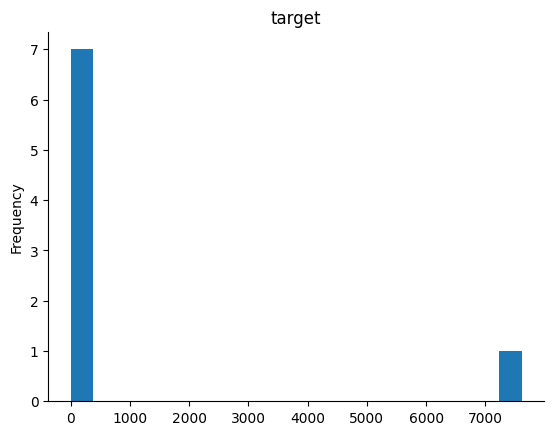

In [ ]:
from matplotlib import pyplot as plt
_df_1['target'].plot(kind='hist', bins=20, title='target')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
data.head(5)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [1]:
!pip install transformers
!pip install datasets


In [22]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import load_dataset
import torch

# Проверка доступности GPU
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device('cpu')
    print("GPU not available. Using CPU.")

model_name = "bert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name).to(device)

dataset = load_dataset("csv", data_files={ "train": "./train.csv" })

# тут поменяем
ds = dataset.rename_column('target', 'label')

from datasets import DatasetDict

# Разделение данных на тренировочные и тестовые
dataset_split = ds['train'].train_test_split(test_size=0.2, seed=42)

# Создание словаря для датасетов
dataset = DatasetDict({
    'train': dataset_split['train'],
    'test': dataset_split['test']
})

Using GPU: Tesla T4


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
def tokinize_function(examples):
  return tokenizer(examples["text"], padding="max_length", truncation=True)

tokenized_datasets = dataset.map(tokinize_function, batched=True)
# Убедитесь, что метки включены в данные после токенизации
tokenized_datasets.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

Map:   0%|          | 0/6090 [00:00<?, ? examples/s]

Map:   0%|          | 0/1523 [00:00<?, ? examples/s]

In [17]:
pd.read_csv("./test.csv").head(5)

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [24]:
from torch.utils.data import dataloader

print(tokenized_datasets)

small_train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(1000))
small_eval_dataset = tokenized_datasets["test"].shuffle(seed=42).select(range(1000))

DatasetDict({
    train: Dataset({
        features: ['id', 'keyword', 'location', 'text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 6090
    })
    test: Dataset({
        features: ['id', 'keyword', 'location', 'text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1523
    })
})


In [25]:
from transformers import Trainer, TrainingArguments

# Параметры обучения
training_args = TrainingArguments(
    output_dir="./results",                # Папка для сохранения результатов
    evaluation_strategy="epoch",           # Оценка на каждом шаге эпохи
    learning_rate=2e-5,                    # Скорость обучения
    per_device_train_batch_size=8,         # Размер пакета для тренировки
    per_device_eval_batch_size=8,          # Размер пакета для оценки
    num_train_epochs=3,                    # Количество эпох
    weight_decay=0.01,                     # Коэффициент регуляризации

)

# Инициализация Trainer
trainer = Trainer(
    model=model,                           # Модель для тренировки
    args=training_args,                    # Параметры тренировки
    train_dataset=small_train_dataset,  # Тренировочный набор данных
    eval_dataset=small_eval_dataset,    # Тестовый набор данных для оценки
)

# Обучение модели
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,No log,0.454368
2,No log,0.429388
3,No log,0.424579


TrainOutput(global_step=189, training_loss=0.4328219701373388, metrics={'train_runtime': 358.3196, 'train_samples_per_second': 8.372, 'train_steps_per_second': 0.527, 'total_flos': 789333166080000.0, 'train_loss': 0.4328219701373388, 'epoch': 3.0})

In [26]:
# Оценка модели на тестовом наборе данных
eval_results = trainer.evaluate()
print("Evaluation results:", eval_results)

# Получение предсказаний
predictions = trainer.predict(tokenized_datasets['test'])
print("Predictions:", predictions.predictions)

Evaluation results: {'eval_loss': 0.4245791733264923, 'eval_runtime': 29.7375, 'eval_samples_per_second': 33.628, 'eval_steps_per_second': 2.119, 'epoch': 3.0}
Predictions: [[-1.2967212   1.8954815 ]
 [ 1.2339159  -1.024502  ]
 [-0.5047488   1.3389549 ]
 ...
 [ 0.49459383 -0.02923186]
 [ 0.892405   -0.23240487]
 [ 1.2830863  -1.0631787 ]]


In [27]:
# Сохранение модели и токенизатора
model.save_pretrained("./saved_model")
tokenizer.save_pretrained("./saved_model")


('./saved_model/tokenizer_config.json',
 './saved_model/special_tokens_map.json',
 './saved_model/vocab.txt',
 './saved_model/added_tokens.json',
 './saved_model/tokenizer.json')

In [29]:
from transformers import pipeline

# Загрузка модели и токенизатора
model = AutoModelForSequenceClassification.from_pretrained("./saved_model")
tokenizer = AutoTokenizer.from_pretrained("./saved_model")

# Создание пайплайна для предсказаний
nlp_pipeline = pipeline("text-classification", model=model, tokenizer=tokenizer)

# Пример использования модели для предсказаний
predictions = nlp_pipeline("i am ill")
print(predictions)

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


[{'label': 'LABEL_0', 'score': 0.89070725440979}]
